# EU GNU Radio Days 2021 challenge

### Solution by Daniel Estévez

In this challenge we are given a recording of some RF transmissions and we are told that in this recording there are seven European speakers. Our goal is to identify the messages exchanged by the speakers and their countries of origin. The challenge description contains a number of clues and some intermediate steps posed as questions to help us.

One of the clues is that six of the seven speakers like GPS signals, and that they are using 1.2281 Mb/s. As usual, it is helpful to first look at the waterfall of the recording in `inspectrum` or a similar tool to detect anything that might be obvious at first glance.

A screenshot of the waterfall is shown here:

![Recording shown in inspectrum](inspectrum_screenshot.png "Recording shown in inspectrum")

The recording consists of a number of wideband bursts at a centre frequency of 3.85 MHz. The bandwidth of these bursts is consistent with the 1.2281 Mb/s given in the challenge description. Using the phase versus time plot in inspectrum we can even see that the bursts are BPSK-modulated, as expected for a GPS-like signal.

We begin by working in GNU Radio. Our maing goal is to demodulate the BPSK bursts. We can do this because the SNR is strong enough to detect each individual DSSS chip individually. A typical GPS signal would have much less SNR, so that demodulation needs to be done by integrating coherently many chips using the correlation with the known PN code.

The GNU Radio flowgraph is in `eugr_challenge.grc` and a screenshot is shown here:

![GNU Radio flowgraph](gr_flowgraph.png "GNU Radio flowgraph")

The main part of the flowgraph is a BSPK demodulator. We downconvert the bursts at 3.85 MHz to baseband, decimating by 4 to save some computations later, use a Costas loop to recover the suppressed carrier, and then the Symbol Sync block to recover the symbol clock and decimate to one sample per symbol. The BPSK symbols are saved to a file that will be analyzed in this notebook. As part of the downconversion we also include a gain parameter in order to make the amplitude of the BPSK bursts approximately equal to one, as required by the Costas loop and Symbol Sync blocks. The symbol rate used for the Symbol Sync block has been found by simple cyclostationary analysis (spectrum of `x[n] * conj(x[n-1])`) and is very close to the one given in the challenge description.

The flowgraph contains other sections that will help us solve some of the intermediate questions. In one of these sections we integrate the power in blocks of 10000 samples. In the other section we compute the average carrier frequency as reported by the Costas loop.

In [1]:
%matplotlib inline

import collections

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'w'

### Question 1. What is the message from the speaker who does not enjoy GPS reception? what is the common communication protocol followed by this bitstream?

The speaker who doesn't like GPS is actually hiding in plain sight. If we plot the average power measured by our GNU Radio flowgraph we see that the BPSK bursts follow a specific pattern. This is actually ASK modulation.

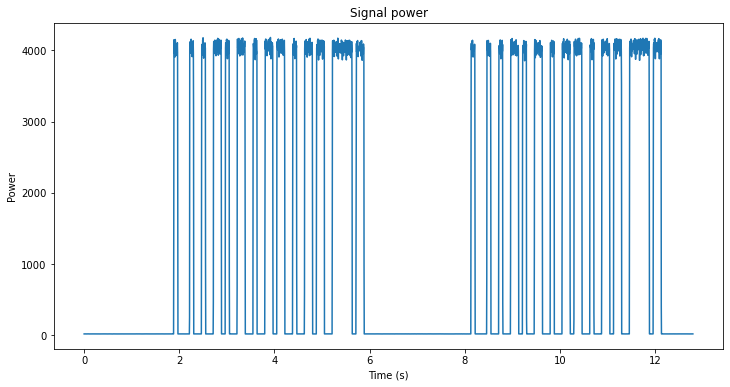

In [2]:
pwr = np.fromfile('avg_pwr.f32', dtype='float32')
plt.plot(np.arange(pwr.size)/250, pwr)
plt.title('Signal power')
plt.ylabel('Power')
plt.xlabel('Time (s)');

Just to be sure, we can check that the two transmissions in the recording contain exactly the same ASK pattern by overlaying them.

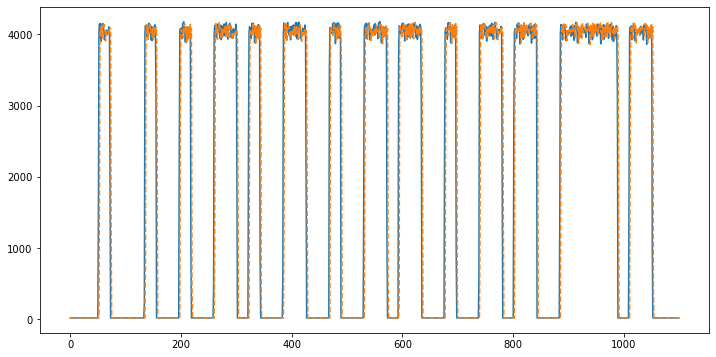

In [3]:
plt.plot(pwr[470-50:][:1100])
plt.plot(pwr[2030-50:][:1100], '--');

After some fiddling, we can manually estimate the sampling clock rate and phase for this ASK signal in order to obtain the bits.

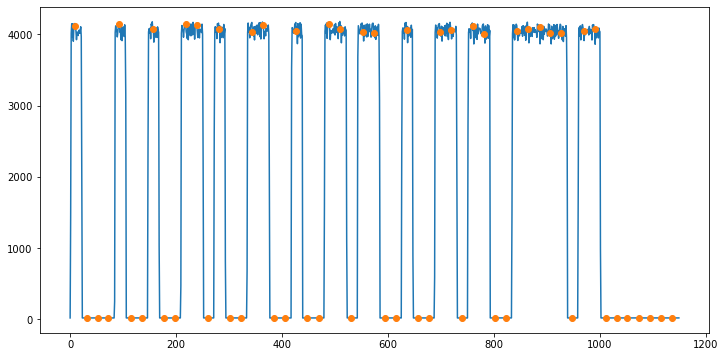

In [4]:
sps = 21-0.15
ask_packet = pwr[470:][:1150]
plt.plot(ask_packet)
locs = np.int32(np.arange(sps/2, ask_packet.size, sps))
plt.plot(locs, ask_packet[locs], 'o');

In [5]:
bits = ask_packet[locs] > 2000

The autocorrelation of the bits gives us a clue. It seems that there are things that repeat every 10 bits.

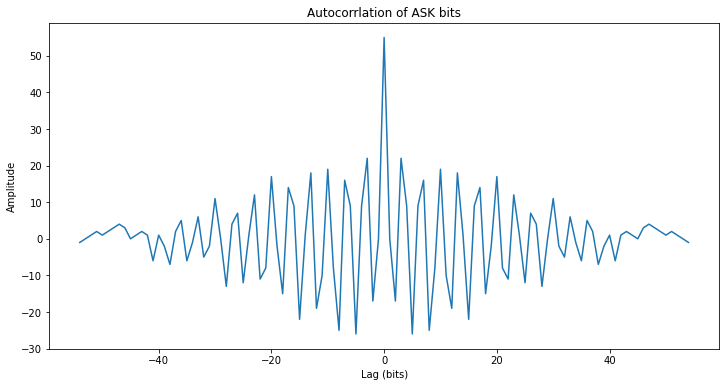

In [6]:
plt.plot(
    np.arange(-bits.size+1, bits.size),
    scipy.signal.correlate(2*bits.astype('int')-1, 2*bits.astype('int')-1))
plt.title('Autocorrlation of ASK bits')
plt.ylabel('Amplitude')
plt.xlabel('Lag (bits)');

We show the bits in a matrix of 10 columns where the bits are written row by row. We see that the first column is always 1 and the two last columns are always 0. This makes us suspect that the coding used here is UART.

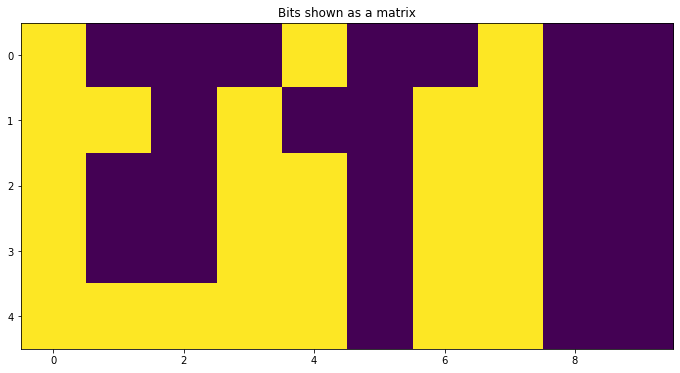

In [7]:
bitsq = bits[:bits.size//10*10].reshape((-1, 10))
plt.imshow(bitsq)
plt.title('Bits shown as a matrix');

There is somthing slightly odd about this UART implementation, which is that the start bit is 1, and the stop bit is zero. Usually this would be the other way around. However, the rest of the UART implementation is standard and we can read the ASCII characters by dropping the first and last columns and reading the data in LSB order.

We see that the message is "Hello".

In [8]:
bytes(np.packbits(bitsq[:, 1:-1][:, ::-1]))

b'Hello'

### Question 2.  What is the coarse frequency offset complying with the legal HF ham radio band, notwithstanding possible channelization considerations? What is the fine frequency offset between transmitter and receiver local oscillator?

We already know that the coarse frequency of the BPSK bursts is 3.85 MHz. In the description of the challenge we are told that the signal has been transmitted by a USRP B210 in some HF band, then mixed with a 25 MHz LO, and recorded with an oscilloscope.

Therefore, assuming that the LO was below the RF frequency, we see that the transmit frequency must have been 25 + 3.85 = 28.85 MHz, corresponding to the 10 metre ham radio band. In fact, this band covers 28 - 29.7 MHz, so the BPSK bursts fit nicely into the band.

An alternative explanation is that the LO was above the RF frequency, and so the transmit frequency was 25 - 3.85 = 21.15 MHz. This is also a ham radio band, namely the 15 metre band, but since it covers 21 - 21.45 MHz it is too narrow to contain these BPSK bursts, so we discard this explanation.

In order to obtain the frequency offset between the transmitter and receiver local oscillators, we look at the residual carrier frequency after the BPSK bursts have been downconverted to baseband in GNU Radio. This is available from the Costas loop frequency output.

In [9]:
freq = np.fromfile('costas_freq.f32', dtype='float32')
freq = freq/(2*np.pi)*2.5e6

The reading of the Costas loop frequency output is only correct when there is a BPSK burst being transmitted (compare the plot below with the plot of the power of the signal above). We can zoom in to the interesting part of the plot and see that the residual carrier frequency is around 229.8 Hz, so this must be the frequency offset between the local oscillators of the transmitter and receiver.

Average frequency 229.83298 Hz


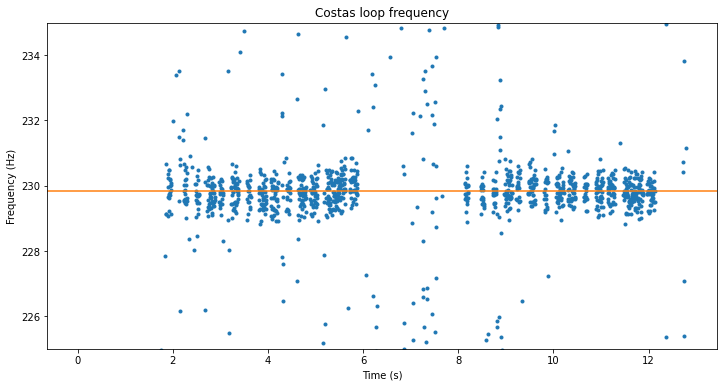

In [10]:
plt.plot(np.arange(freq.size)/250, freq, '.')
freq_sel = freq[np.abs(freq - 230) < 5]
avg_freq = np.average(freq_sel)
plt.axhline(y=avg_freq, color='C1')
plt.ylim((225,235))
print('Average frequency', avg_freq, 'Hz')
plt.title('Costas loop frequency')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)');

### Question 3. What is the coding scheme of the six GPS receiver enthusiasts, considering their datarate is known?

In order to solve this question, we must first investigate the BPSK symbols that we have demodulated with our GNU Radio flowgraph. There are many possible dead ends and detours that one can go with this investigation. Here we show a direct way to the solution, but the stories of the possible dead ends are also interesting.

We start by loading the symbols and plotting them.

In [11]:
x = np.memmap('symbols.f32', dtype='float32')

Here we see the first two BPSK bursts. We notice something very strange, which is that this is not a regular BPSK modulation. The symbols are +1, -1, but also 0.

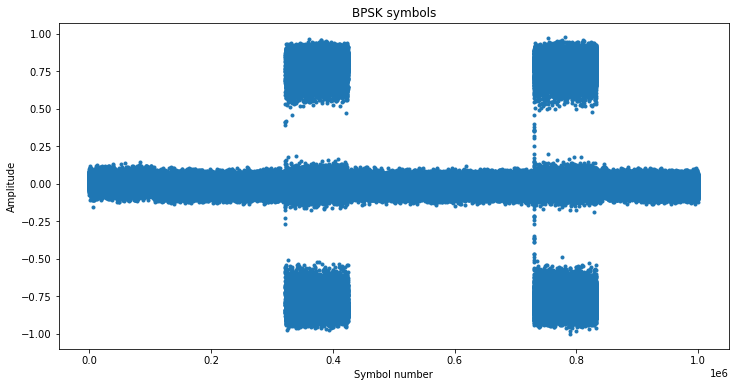

In [12]:
N = 1000000
plt.plot(x[2*N:][:N], '.')
plt.title('BPSK symbols')
plt.xlabel('Symbol number')
plt.ylabel('Amplitude');

We select the first burst. We will only work with this portion of the demodulated data.

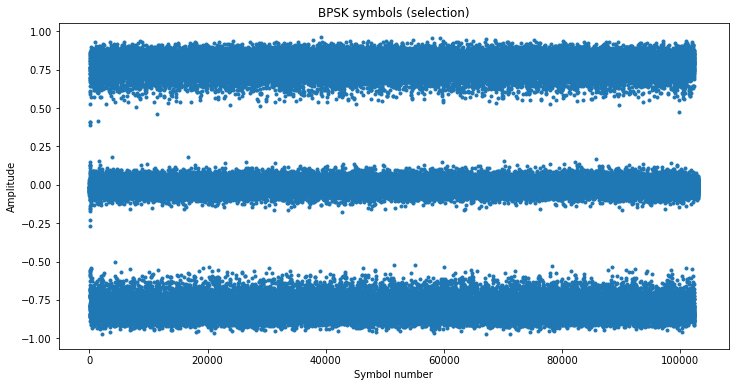

In [13]:
y = x[2*N+322000:][:103000]
plt.plot(y, '.')
plt.title('BPSK symbols (selection)')
plt.xlabel('Symbol number')
plt.ylabel('Amplitude');

If we zoom in we see that many of the symbols are indeed zero.

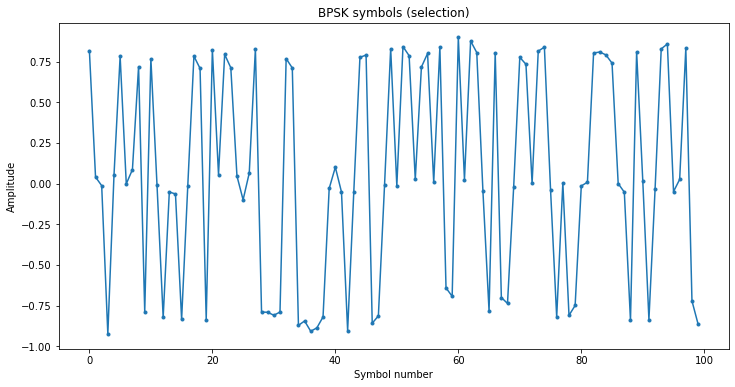

In [14]:
plt.plot(y[20000:][:100], '.-')
plt.title('BPSK symbols (selection)')
plt.xlabel('Symbol number')
plt.ylabel('Amplitude');

Why do we have symbols which are zero? This is an important question, and can provide clues to the solution but might also lead us in the wrong direction.

For instance, we could think that there are two BPSK PN codes transmitted simultaneously by summing them, so that the possible values of their sum are +2, 0 and -2. This is not the case here.

We will come back to this later, but for now we will mention that majority voting is one of the tools that are used in GNSS to multiplex several PN streams onto the same carrier. The advantage of this non-linear way of combining PN codes is that the output can be constant amplitude (consisting only of the symbols +1 and -1), which is better for the satellite PA. When there is an even number of streams we can have ties with majority voting. Usually, some additional mechanism is used to break ties, rather than transmitting a zero, which breaks the constant ampltiude property.

We look at the autocorrelation of the BPSK burst to try to gain any information about the structure of these bursts. We see that there are autocorrelation peaks at several multiples of 1023 chips. Since the length of the PN codes used in GPS L1 C/A is also 1023 chips, it seems that these GPS-like signals also use this length for the PN codes.

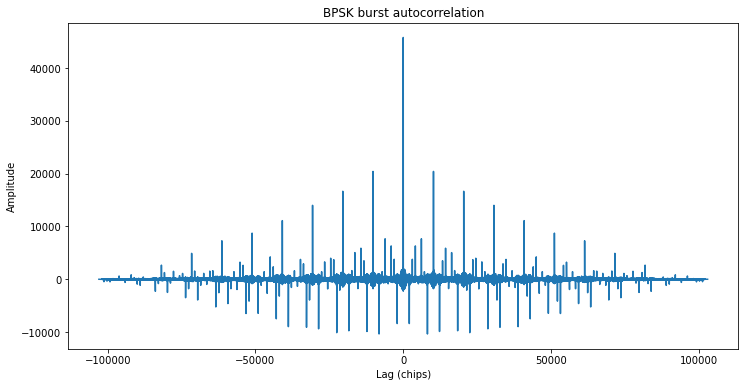

In [15]:
corr = scipy.signal.correlate(y, y)
corr_lag = np.arange(-y.size+1, y.size)
plt.plot(corr_lag, corr)
plt.title('BPSK burst autocorrelation')
plt.xlabel('Lag (chips)')
plt.ylabel('Amplitude');

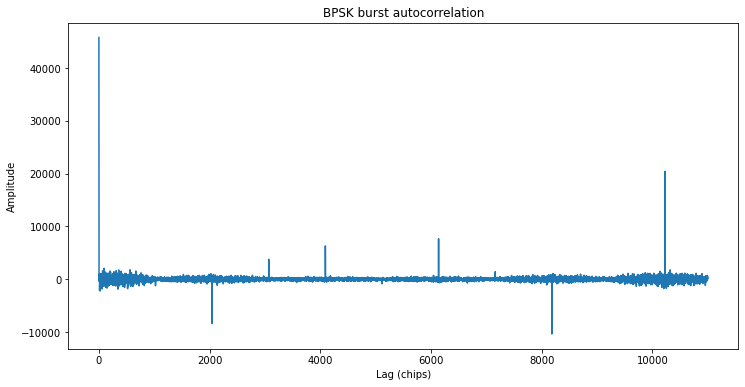

In [16]:
plt.plot(corr_lag[corr.size//2:][0:11000], corr[corr.size//2:][0:11000])
plt.title('BPSK burst autocorrelation')
plt.xlabel('Lag (chips)')
plt.ylabel('Amplitude');

In [17]:
np.where(np.abs(corr[corr.size//2:][0:11000]) > 5000)[0]

array([    0,  2046,  4092,  6138,  8184, 10230])

A good clue is given in the challenge description: "although Gold codes are too complex and simpler coding schemes are best suited for their exchanges". This makes us think of m-sequences generated by LFSRs, which are the building blocks for Gold codes.

With this idea in mind, we try to match all the possible 1023 chip m-sequences with the BPSK burst. We know that each possible 1023 chip m-sequence is a circular shift of the m-sequence generated by an LFSR defined by a primitive polynomial of degree 10 with the starting value of the register set to all ones.

The function below implements an LFSR given some taps (non-zero coefficients of the polynomial).

In [18]:
def lfsr(taps, size=10):
    taps = np.array(taps)
    taps = taps[taps != 0]
    taps = taps - 1
    state = np.ones(size, dtype='uint8')
    output = np.empty(2**size-1, dtype='uint8')
    for j in range(output.size):
        output[j] = state[0]
        new = np.sum(state[taps]) % 2
        state[1:] = state[:-1]
        state[0] = new
    return output

The list of the coefficients of primitive polynomials over GF(2) can be downloaded from [OEIS](https://oeis.org/A058943/b058947.txt). We parse this file to obtain the taps corresponding to primitive polynomials of degree 10. There are 60 such polynomials.

In [19]:
with open('b058947.txt') as f:
    ls = f.readlines()
polys = [a for a in [a.split()[-1] for a in ls if len(a.split())] if len(a) == 11]
primitive_taps = [[10-j for j,k in enumerate(p) if k == '1'] for p in polys]
len(primitive_taps)

60

In order to try all the circular shifts of the sequences efficiently we use circular correlation implemented by means of the Fourier transform. First we divide our received data into blocks of 1023 chips.

In [20]:
l = 1023
z = y[:y.size//l*l].reshape((-1, l))

Then we Fourier transform each block as well as each of the 60 m-sequences generated by all the primitive polynomials.

In [21]:
fz = np.fft.fft(z)
flfsr = np.array([np.fft.fft(2*lfsr(taps).astype('float')-1) for taps in primitive_taps])

We multiply one of the Fourier transforms by the complex conjugate of the other one and apply an IFFT to get back to the lag domain. We get a peak where a correlation is found, so we perform a max search to get that peak.

In [22]:
fprod = fz.reshape((-1, 1, 1023)) * np.conjugate(flfsr).reshape((1, -1, 1023))
prod_lag = np.max(np.abs(np.fft.ifft(fprod)), axis=-1)

When we plot the correlations we see that there are a few of them that are strong, while the remaining ones are weak.

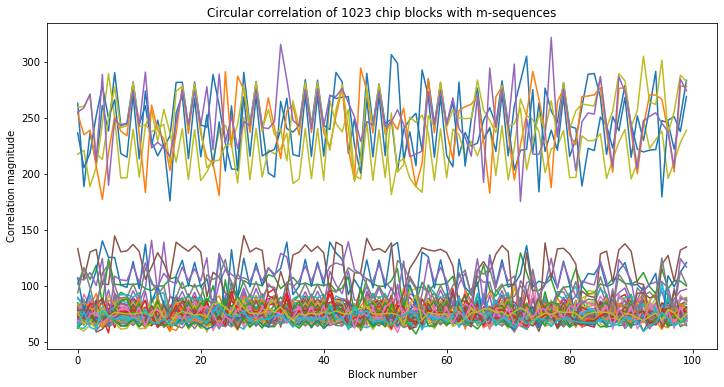

In [23]:
plt.plot(prod_lag)
plt.title('Circular correlation of 1023 chip blocks with m-sequences')
plt.ylabel('Correlation magnitude')
plt.xlabel('Block number');

In fact there are exactly 6 strong correlations. These correspond to the 6 speakers who like GPS signals. This indicates that each of them is using a different m-sequence as a PN code.

In [24]:
active_lfsrs = np.where(np.max(prod_lag, axis=0) > 175)[0]
active_lfsrs

array([ 0, 18, 20, 21, 28, 34])

The polynomials used to define these six m-sequences are:
* $x^{10} + x^3 + 1$
* $x^{10} + x^8 + x^6 + x + 1$
* $x^{10} + x^8 + x^6 + x^5 + x^3 + x + 1$
* $x^{10} + x^8 + x^7 + x^2 + 1$
* $x^{10} + x^8 + x^7 + x^6 + x^5 + x^4 + x^3 + x + 1$
* $x^{10} + x^9 + x^6 + x^3 + x^2 + x + 1$.

In [25]:
[primitive_taps[a] for a in active_lfsrs]

[[10, 3, 0],
 [10, 8, 6, 1, 0],
 [10, 8, 6, 5, 3, 1, 0],
 [10, 8, 7, 2, 0],
 [10, 8, 7, 6, 5, 4, 3, 1, 0],
 [10, 9, 6, 3, 2, 1, 0]]

We take only those 6 m-sequences, perform the correlations via FFT again, and look at the location where the peak is found. We see that each of the m-sequences always appears in the same phase (circular shift) every time it is used.

In [26]:
fprod_good = fz.reshape((-1, 1, 1023)) * np.conjugate(flfsr[active_lfsrs]).reshape((1, -1, 1023))
prod_lag_good = np.fft.ifft(fprod_good)

In [27]:
corr_pos = np.unique(np.argmax(np.abs(prod_lag_good), axis=-1), axis = 0)
corr_pos

array([[144, 823, 357, 170, 915, 779]])

If we plot the values of the correlations, we see that each of the 6 m-sequences transmits a different binary sequence.

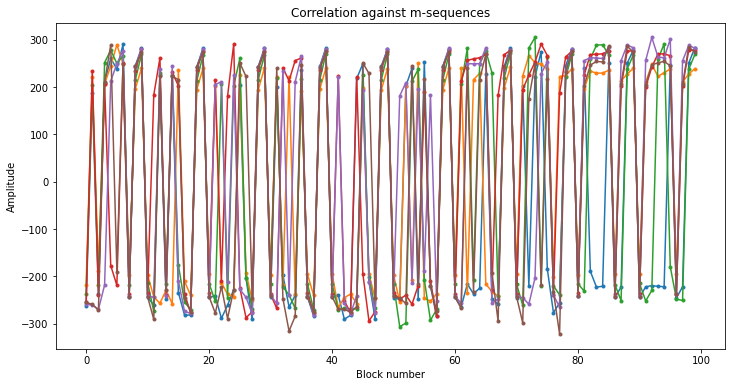

In [28]:
prn_symbols = prod_lag_good[:, np.arange(6), corr_pos.ravel()].real
plt.plot(prn_symbols, '.-')
plt.title('Correlation against m-sequences')
plt.xlabel('Block number')
plt.ylabel('Amplitude');

In order to answer the question **what is the coding scheme?** completely, let us check that the coding method is majority voting of the 6 PN sequences, where 0 is used if there is a tie. We first construct the PN sequences.

In [29]:
pn_seqs = [2*np.roll(lfsr(primitive_taps[a]), r).astype('float')-1
           for a, r in zip(active_lfsrs, corr_pos[0])]
pn_seqs = np.array(pn_seqs)

Next we implement a majority voting scheme according to these 6 PN sequences modulated with the symbol streams we have obtained above.

In [30]:
a = pn_seqs.reshape((1, 6, 1023)) * np.sign(prn_symbols).reshape((100, 6, 1))
majority = np.sign(np.sum(a, axis=1)).ravel()

Now we perform hard decision according to the symbol +1, 0, -1 on the demodulated BPSK chips obtained from the GNU Radio flowgraph.

In [31]:
y_hard = np.zeros(y.size)
y_hard[y < -0.2] = -1
y_hard[y > 0.2] = 1

If we compare the received data with the sequence we have constructed with majority voting, we see that they do not line up correctly at the beginning, because we haven't been careful enough to trim the received data to the start chip, but besides this detail they are identical.

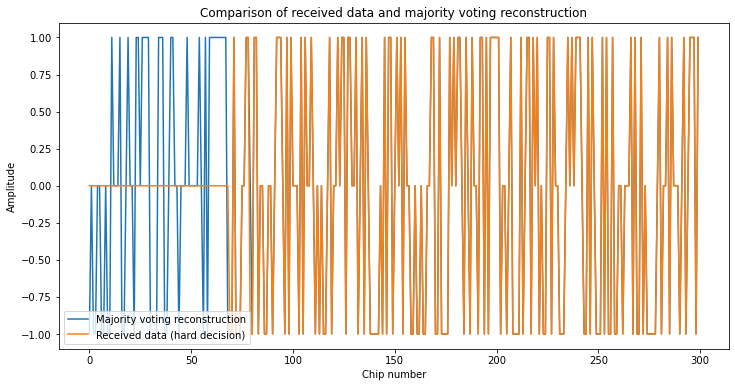

In [32]:
plt.plot(majority[:300])
plt.plot(y_hard[:300])
plt.title('Comparison of received data and majority voting reconstruction')
plt.xlabel('Chip number')
plt.ylabel('Amplitude')
plt.legend(['Majority voting reconstruction', 'Received data (hard decision)']);

In fact 96% of the chips coincide, so the conclusion is that the coding scheme used by the 6 speakers is 6 BPSK-modulated PN sequences defined by 1023 chip m-sequences multiplexed into a tri-level signal according to majority voting.

In [33]:
np.average(y_hard[:majority.size] == majority)

0.9624828934506354

### Question 4. What are the bit sequences transmitted by these six speakers?

The bit sequences have been plotted above. We can list them here:

In [34]:
(prn_symbols.T >= 0)*1

array([[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0,

### Question 5. How are these bits packed as sentences?

The seventh speaker, who used ASK and UART gives us the clue here. If we look at the bit sequences of the 6 speakers using PN codes we see that they also use UART. Some care needs to be taken to handle the possible 180º ambiguity in the Costas loop, which was not present in the demodulation of ASK.

We can read the messages in the same manner we did for the seventh speaker. We find salutations in six different European languages.

m-sequence 0 b'Buongiorno'
m-sequence 1 b'Bonjour   '
m-sequence 2 b'BuenosDias'
m-sequence 3 b'Zdravo    '
m-sequence 4 b'GutenTag  '
m-sequence 5 b'SeOnOkei  '


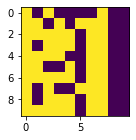

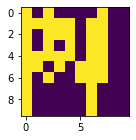

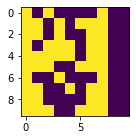

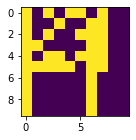

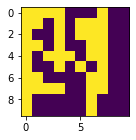

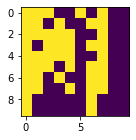

In [35]:
for j in range(6):
    bits = prn_symbols[:, j] >= 0
    bits = 1 ^ bits # because of Costas 180 deg ambiguity
    plt.figure(figsize = (2,2))
    bitsq = bits[:bits.size//10*10].reshape(-1, 10)
    plt.imshow(bitsq)
    message = bytes(np.packbits(bitsq[:, 1:-1][:, ::-1]))
    print(f'm-sequence {j}', message)

### Question 6. What countries do the speakers come from?

A Google search can be used for the less well-known languages. We see that the speaker using ASK is from an English speaking country, such as the UK or Ireland, and that for the 6 speakers using PN codes:

* Buongiorno -> Italy
* Bonjour -> France
* BuenosDias -> Spain
* Zdravo -> Serbia, Croatia or Slovenia
* GutenTag -> Germany
* SeOnOkei -> Finland

Interestingly, it seems that "Se On Okei" means "It's OK" in Finnish, while the other sentences are typical salutations more similar to the English "hello".